# Impact of Covid-19 on Salaries & Employment

The aim of this analysis is to highlight potential impacts that the covid-19 pandemic may have had on the average salary/bonus/total yearly compensation, and also its effects on employment rates.

## Importing Relevant Packages and Datasets

In [1]:
import findspark
findspark.init()

In [2]:
import numpy as np
import pyspark
from pyspark.sql import SparkSession, Row
from pyspark.sql.types import *
import pyspark.sql.functions as F
import pandas as pd
import matplotlib.pyplot as plt
from pyspark.sql.functions import col, to_timestamp, unix_timestamp, to_date, to_date, col, year, month

In [3]:
spark = pyspark.sql.SparkSession.builder.master("local").getOrCreate()

In [4]:
# Let's define our schema
schema = StructType([\
    StructField("date", DateType(), True),\
    StructField("time", StringType(), True),\
    StructField("company", StringType(), True),\
    StructField("level", StringType(), True),\
    StructField("title", StringType(), True),\
    StructField("totalyearlycompensation", IntegerType(), False),\
    StructField("location", StringType(), True),\
    StructField("yearsofexperience", FloatType(), False),\
    StructField("yearsatcompany", FloatType(), False),\
    StructField("tag", StringType(), True),\
    StructField("basesalary", IntegerType(), False),\
    StructField("stockgrantvalue", IntegerType(), False),\
    StructField("bonus", IntegerType(), False),\
    StructField("gender", StringType(), True),\
    StructField("cityid", StringType(), True),\
    StructField("dmaid", StringType(), True),\
    StructField("race", StringType(), True),\
    StructField("education", StringType(), True)])

# Load and parse the data file, converting it to a DataFrame.
data = spark.read.format("csv")\
    .option("header", "false")\
    .option("delimiter", "\t")\
    .schema(schema)\
    .load("../data/seperated_time_data/cleaned.txt")

## Creating new Column for Month/Year to allow for Grouping

In [93]:
adjusted_data_1 = data.withColumn("date", to_date(col("date"), "yyyy-MM-dd"))\
    .withColumn('month', month("date"))

adjusted_data_2 = adjusted_data_1.withColumn("date", to_date(col("date"), "yyyy-MM-dd"))\
    .withColumn('year', year("date"))

In [94]:
# Combining the columns 'month' and 'year' to a column of DateType()
new_data = adjusted_data_2.withColumn(
    "date",
    F.date_format(F.expr("make_date(year, month, 1)"), "MM/dd/yyyy")
)

## Impact of Covid-19 on all Earnings

In [75]:
# Selecting only the columns we need for our analysis
selected_data = new_data.select(to_date(col("date"),"MM/dd/yyyy").alias("date"), 'totalyearlycompensation', 'basesalary', 'bonus')

In [76]:
# Grouping data by month and year, and calculating the average values per month
grouped_data = selected_data.groupby('date').mean('totalyearlycompensation', 'basesalary', 'bonus')

In [77]:
# Rounding the data to the nearest 2 decimals
rounded_data1 = grouped_data.withColumn("avg(basesalary)", F.round(grouped_data["avg(basesalary)"], 2))
rounded_data2 = rounded_data1.withColumn("avg(totalyearlycompensation)", F.round(rounded_data1["avg(totalyearlycompensation)"], 2))
rounded_data3 = rounded_data2.withColumn("avg(bonus)", F.round(rounded_data2["avg(bonus)"], 2))

In [78]:
# Separating the different types of earnings into different datasets and converting to Pandas
tyc_data = rounded_data3.select('date', 'avg(totalyearlycompensation)').toPandas()
salary_data = rounded_data3.select('date', 'avg(basesalary)').toPandas()
bonus_data = rounded_data3.select('date', 'avg(bonus)').toPandas()

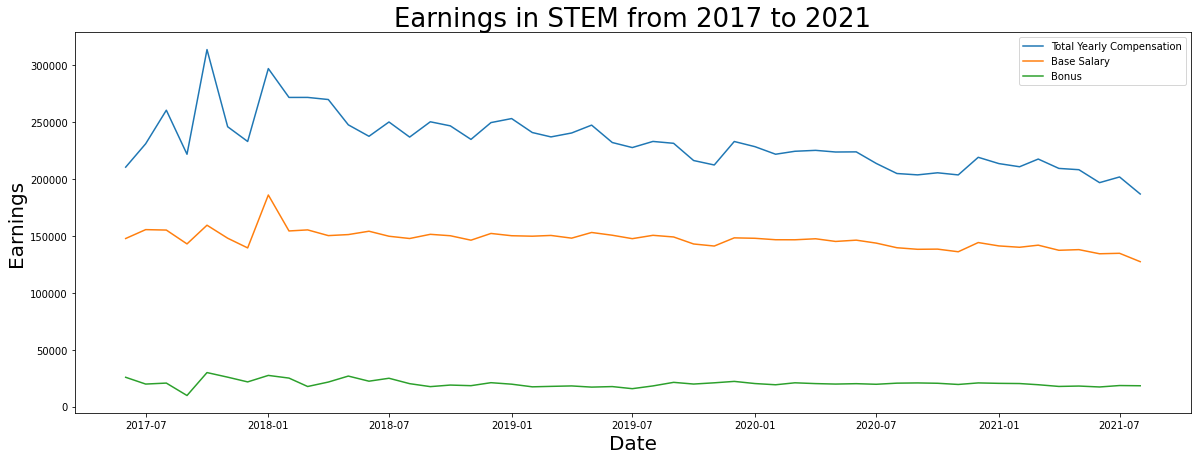

In [88]:
# Plotting each earning type on a line chart
fig, ax = plt.subplots(figsize=(20, 7))
tyc_data.plot(x="date", ax=ax)
salary_data.plot(x="date", ax=ax)
bonus_data.plot(x="date", ax=ax)
plt.title("Earnings in STEM from 2017 to 2021", fontsize=26)
plt.xlabel("Date", fontsize=20)
plt.ylabel("Earnings", fontsize=20)
plt.legend(labels=["Total Yearly Compensation", "Base Salary", "Bonus"], loc='best')
plt.show()

The chart above shows that there was virtually no effect on average earnings related to Covid-19. The pandemic began in early 2020, and the chart does not show any noticeable increase/decrease in earnings, rather the earnings just continue to decline slightly from 2018. 

# Identifying the number of Records created Each Month

In [80]:
# Selecting only the columns we need for our analysis
selected_data = new_data.select(to_date(col("date"),"MM/dd/yyyy").alias("date"))

In [85]:
# Grouping data by month and year, and calculating the number of entries for each month
grouped_data = selected_data.groupby('date').count().toPandas()

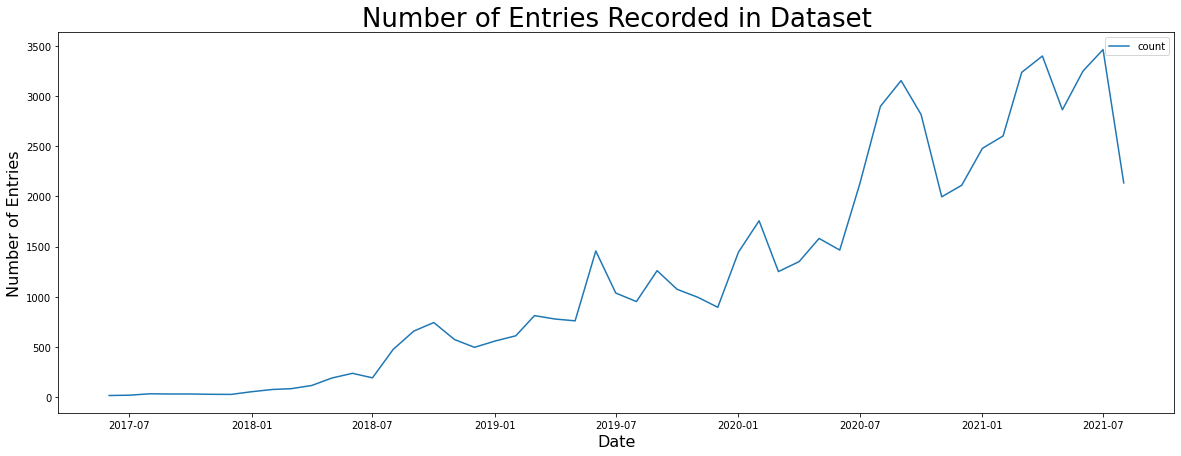

In [97]:
# Plotting the number of entries recorded each month
fig, ax = plt.subplots(figsize=(20, 7))
grouped_data.plot(x="date", ax=ax)
plt.title("Number of Entries Recorded in Dataset", fontsize=26)
plt.xlabel("Date", fontsize=16)
plt.ylabel("Number of Entries", fontsize=16)
plt.show()

There is a similar finding in this chart also, the pandemic does not seem to have an effect on the number of entries recorded each month. We expect that the employment rates are relative to the number of entries recorded, and so we can deduce that the employment rates in the STEM sectors have been steadily increasing since mid-2018.